# AAI 511 Final Project - Group 1

## Table of Contents

### 1. Project Overview
- 1.1 Libraries and Preprocessing Tools 
### 2. Feature Extraction Approaches
- 2.1 Mido Exploration (Pitch, Velocity, Timing)
- 2.2 PrettyMIDI Exploration (Piano Roll Representation)
- 2.3 Music21 Exploration (Symbolic/Score-based Analysis)
### 3. Next Steps
- 3.1 Brief discussion of all four models (Model A, B, C, C2)
### 4. Model A - CNN-BiLSTM with Attention (Mido + PrettyMIDI Features)
- 4.1 Visual Feature Distributions
    - Figure 1 - Tempo Distributions
    - Figure 2 - Pitch Mean Distributions
    - Figure 3 - Velocity Mean Distributions
    - Figure 4 - Time Mean Distribution
- 4.2 Data Preparation
- 4.3 Initialize Model
- 4.4 Model Architecture 
- 4.5 Training and Evaluation
    - Confusion Matrix Analysis
    - Classification Report Summary
### 5. Model B - CNN-BiLSTM Composer Classification
- 5.1 Data Processing and Augmentation
    - Pitch shifting
    - Velocity jitter
    - Class balancing with WeightedRandomSampler
- 5.2 Model Architecture and Evaluation
    - Multiple model iterations (confusion matrices & classification reports)
- 5.3 Summary of CNN-BiLSTM Model
### 6. Model C - CNN-MLP Multimodal Composer Classification
- 6.1 Model Architecture
- 6.2 Loading Piano Rolls
- 6.3 Loading Engineered Features
    - Features extracted by extract_comprehensive_musical_features
- 6.4 Summary of CNN-MLP Multimodal Model
    - Next Steps: Exploring Temporal Relationships
### 7. Model C2 - CNN-LSTM-MLP Multimodal Composer Classification (Iteration of Model C)
- 7.1 Model Architecture, Training, and Evaluation
### 8. Conclusion and Future Work


# 1. Project Overview

The main goal of this project is to develop a machine learning model that has the ability to classify classical music composers based on MIDI data. Our approach focuses on extracting musical features - such as pitch, velocity, tempo, and time, using various tools. To cover all our bases, each team member initially focused on a different type of feature extraction, such as Mido, Music21, and PrettyMIDI. 

All extracted features are evaluated using a base model architecture built around CNN and Bidirectional LSTM layers, with adjustments respective to the feature set of each approach. Multiple modeling attempts were conducted to cover different approaches and improve performance. 

Throughout this notebook, we present and compare the various feature extraction methods, modeling approaches, and their results, all leading to the best performing model.

## 1.1 Libraries and Preprocessing Tools

In [ ]:
# Load Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import pickle
from torch.utils.data import TensorDataset, DataLoader
import torch
import mido
import music21

In [4]:
import importlib
import utils

importlib.reload(utils)

from utils import *

print("🔧 Utils and dependencies imported")
device = get_device()

🔧 Utils and dependencies imported
🚀 Using CUDA GPU: NVIDIA GeForce RTX 4070 Ti SUPER


In [55]:
import importlib
import utils_ppatel
importlib.reload(utils_ppatel)

print(dir(utils_ppatel))

['Attention', 'ComposerCNNBiLSTMWithAttention', 'DataLoader', 'LabelEncoder', 'StandardScaler', 'TARGET_COMPOSERS', 'TensorDataset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'accuracy_score', 'classification_report', 'clean_dataset', 'compute_class_weight', 'compute_class_weights', 'confusion_matrix', 'download_extract_dataset', 'extract_all_features', 'extract_chords_tempo', 'extract_features', 'extract_mido_features', 'get_model', 'gpu_device', 'kagglehub', 'mido', 'nn', 'np', 'os', 'pd', 'plot_pitch_distribution', 'plot_tempo_distribution', 'plot_time_distribution', 'plot_velocity_distribution', 'plt', 'prepare_data', 'pretty_midi', 'shutil', 'sns', 'torch', 'train_and_evaluate', 'train_test_split', 'zipfile']


In [5]:
import utils_Sean
from utils_Sean import *
importlib.reload(utils_Sean)

print(dir(utils_Sean))

['CNNBiLSTMAttentionClassifier', 'CNNBiLSTMAttentionClassifier2', 'CNNBiLSTMClassifier', 'CNNBiLSTMClassifier2', 'CachedMidiDataset', 'ConfusionMatrixDisplay', 'Dataset', 'EarlyStopping', 'F', 'GradScaler', 'SimpleCNN', 'WeightedRandomSampler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'accuracy_score', 'autocast', 'classification_report', 'confusion_matrix', 'evaluate_confusion_matrix', 'f1_score', 'make_weighted_sampler_and_loss', 'midi_to_pianoroll', 'nn', 'np', 'os', 'pad_or_truncate', 'pitch_shift', 'plt', 'preprocess_and_cache', 'pretty_midi', 'stratified_split', 'time', 'time_stretch', 'torch', 'train_and_evaluate', 'train_test_split', 'velocity_jitter']


- In the initial phase we divided the work such that each member would explore one of these toolkits for working with MIDI files
  - Mido: Payal
  - Pretty Midi: Sean
  - [Music21](https://www.music21.org/music21docs/): Antonio


# 2. Feature Extraction Approaches


## 2.1 Mido Exploration

The Mido library is used to extract basic features from MIDI files, focusing on raw features such as pitch, velocity, and timing (duration between notes). Specifically, it extracts the first max_e note on events with positive velocity, recording each event's note, intensity, and duration since the previous event. This approach translates the MIDI sequence into a numerical vector (which we can then use to input features for our models).

To handle sequences of different lengths, the extracted notes are padded with zeros and cut to maintain a fixed length feature vector. 

Though this Python library seems sufficient on its own, Mido only extracts certain aspects of music, specifically the note level performance. It does not provide muscial features such as tempo changes, or chord recognition.

Due to these limitations, it is important to pair Mido with other feature extraction tools such as PrettyMIDI or Music21. Combining multiple feature extraction methods improves machine learning models for classification tasks, such as this one.

### Reference
Hernandez-Olivan, C., & Beltran, J. R. (2023). Musicaiz: A python library for symbolic music generation, analysis and visualization. SoftwareX, 22, 101365. https://doi.org/10.1016/j.softx.2023.101365

In [56]:
# utils_ppatel.py
# Mido
def extract_features(midi_path, max_e=1000):
    try:
        # Load MIDI file
        midi_file = mido.MidiFile(midi_path)
        notes = []
        # Loop through MIDI files
        for e in midi_file:
            # Only the note being played
            if e.type == 'note_on' and e.velocity > 0:
                # Pitch (note), time, velocity
                notes.append((e.note, e.velocity, e.time))
            # Stop collecting after max events
            if len(notes) >= max_e:
                break
        if not notes:
            return None
        # Convert list to numpy array
        matrix_n = np.array(notes)
        # Pad with zeros if its less than the max. If more, cut.
        if matrix_n.shape[0] < max_e:
            padding = max_e - matrix_n.shape[0]
            matrix_n = np.pad(matrix_n, ((0, padding), (0, 0)), mode='constant')
        else:
            matrix_n = matrix_n[:max_e]
        # Flatten - 1D feature vector
        return matrix_n.flatten()
    except Exception as error:
        print(f"Skip {midi_path}: {error}")
        return None

## 2.2 PrettyMIDI Exploration
Exploration of PrettyMIDI was done by creating a normalized piano roll reprsentation of all midi files and then feeding it to a simple CNN classifier. After investigation, it was clear that PrettyMIDI would be an ideal choice for this application. In addition to creating a piano roll representation, it also allows access to other features such as velocity and duration of the notes.

#### Reference
Raffel, C., & Ellis, D. P. W. (2014). Intuitive Analysis, Creation and Manipulation of MIDI Data with PrettyMIDI. In Proceedings of the 15th International Society for Music Information Retrieval Conference (ISMIR 2014).

In [6]:
# Creating function for converting MIDI file to a piano roll representation
def midi_to_pianoroll(filepath, fs=100, cut_notes=False):
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        # Normalizing piano roll
        piano_roll = midi.get_piano_roll(fs=fs) / 127.0
        # Creating option of removing extremely high/low notes since they could potentially be noise
        if cut_notes:
            piano_roll = piano_roll[21:109, :]
        return piano_roll.astype(np.float32)
    except Exception as e:
        raise ValueError(f"Failed to process MIDI file '{filepath}': {e}")

In [7]:
# Simple CNN for testing PrettyMIDI
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # Shape: (batch, channels, 1, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [10]:
midi_path = "midiclassics\Bach\AveMaria.mid"
roll = midi_to_pianoroll(midi_path, fs=100, cut_notes=False)

tensor_input = torch.tensor(roll).unsqueeze(0).unsqueeze(0)

model = SimpleCNN(num_classes=4)

output = model(tensor_input)
print("Output logits:", output)
print("Predicted class:", torch.argmax(output, dim=1).item())

<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\seanp\AppData\Local\Temp\ipykernel_50808\1186191398.py:1: SyntaxWarning: invalid escape sequence '\B'
  midi_path = "midiclassics\Bach\AveMaria.mid"


Output logits: tensor([[-0.0122, -0.2443,  0.1645, -0.0772]], grad_fn=<AddmmBackward0>)
Predicted class: 2


## 2.3 Music21 Exploration
During the exploration of music21 library and report on its advantages and disadvantages. For this purpose, a small convolutional model was created exploring different configurations of CNN and LSTM layers. Some initial investigation already pointed out that this library is more oriented towards analyzing, searching, and transforming music in symbolic (score-based) forms, and it seems to work best if the workflow is to transform MIDI files into forms where we would analyze harmony/rythm/notation. `Music21 does not have native piano roll support`.

##### Reference
Cuthbert, Michael & Ariza, Christopher. (2010). Music21: A Toolkit for Computer-Aided Musicology and Symbolic Music Data.. Proceedings of the 11th International Society for Music Information Retrieval Conference, ISMIR 2010. 637-642. 

### Downloading the dataset
To ensure consistency and avoid committing data files to GitHub, `download_dataset()` was created. This utility function will automatically download the MIDI dataset from Kaggle, extract it to a local directory, and remove any files or folders not corresponding to the target composers, ensuring that everyone works with the same data structure and content.

In [2]:
paths = download_dataset()
paths

Dataset downloaded and extracted to ../data/kaggle/midiclassics


{'path': '/Users/arr/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1',
 'zip_path': '/Users/arr/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/midiclassics.zip',
 'extract_path': '../data/kaggle/midiclassics'}

In [3]:
piano_rolls, valid_labels = extract_music21_piano_roll_segments(paths['extract_path'])

  9%|▉         | 44/481 [00:30<03:56,  1.85it/s]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Preludiul nr.3 \xeen re minor, BWV 935'>; getting generic Instrument
  warnings.warn(
 19%|█▊        | 90/481 [01:17<08:25,  1.29s/it]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Preludiul nr.6 \xeen mi minor, BWV 938'>; getting generic Instrument
  warnings.warn(
 26%|██▌       | 124/481 [01:45<05:08,  1.16it/s]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Concerto pour violon et orchestre en R\xe9 majeur'>; 

Extracted 481 piano rolls.


In [6]:
import collections
label_counts = collections.Counter(valid_labels)
composer_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
for idx, name in enumerate(composer_names):
    print(f"{name}: {label_counts.get(idx, 0)} samples")

Bach: 122 samples
Beethoven: 133 samples
Chopin: 136 samples
Mozart: 90 samples


Taking a look at the piano roll

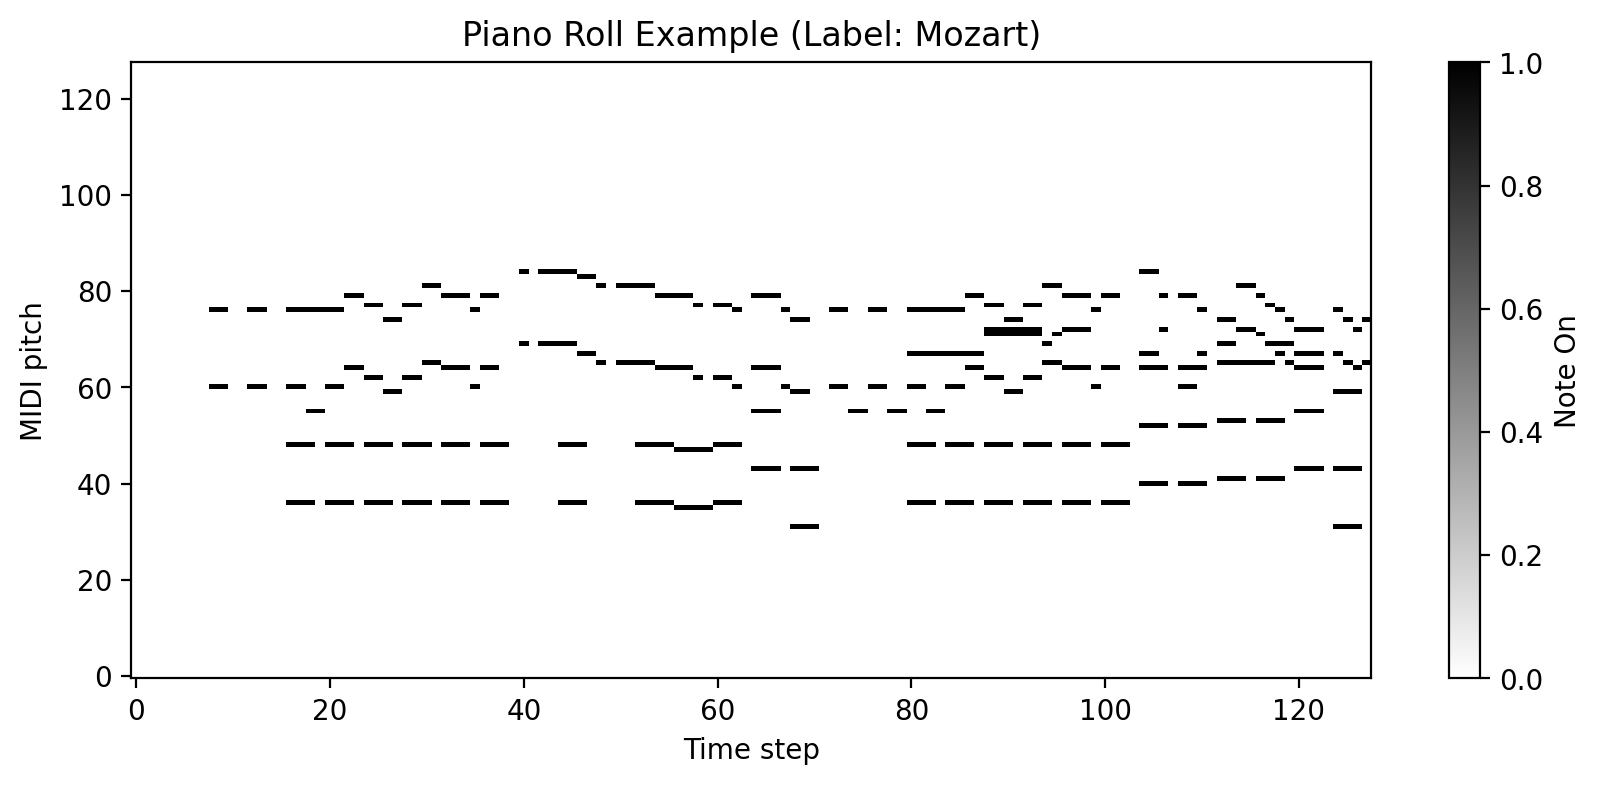

In [7]:
idx = np.random.randint(len(piano_rolls))
plt.figure(figsize=(10, 4))
plt.imshow(piano_rolls[idx], aspect='auto', origin='lower', cmap='gray_r')
plt.xlabel("Time step")
plt.ylabel("MIDI pitch")
plt.title(f"Piano Roll Example (Label: {composer_names[valid_labels[idx]]})")
plt.colorbar(label='Note On')
plt.show()

In [8]:
note_density = [np.mean(np.array(p) > 0) for p in piano_rolls]
for i, name in enumerate(composer_names):
    densities = [note_density[j] for j in range(len(valid_labels)) if valid_labels[j] == i]
    print(f"{name} - Avg. note density: {np.mean(densities):.4f}")

Bach - Avg. note density: 0.0112
Beethoven - Avg. note density: 0.0108
Chopin - Avg. note density: 0.0089
Mozart - Avg. note density: 0.0088


The initial base test uses an architecture with 2 CNN layers followed by 1 LSTM layer. The plan is to observe the results and gather insights to determine the best next steps.

In [14]:
class SimpleCNNLSTM(nn.Module):
    def __init__(self, num_classes, input_time_dim):
        super(SimpleCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d((2,2))
        # After pooling, pitch dim is 64, time dim is input_time_dim//2
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, 1, 128, T)
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)  # Now (batch, 64, 32, T//4)
        # Prepare for LSTM: collapse pitch, transpose to (batch, time, features)
        x = x.mean(dim=2)  # (batch, 64, T//4)
        x = x.permute(0,2,1)  # (batch, T//4, 64)
        out, _ = self.lstm(x)  # (batch, T//4, 64)
        out = out[:,-1,:]      # Take last time step
        out = self.fc(out)
        return out

In [15]:
# Convert to tensors and add channel dimension (N, 1, 128, T)
X = torch.tensor(piano_rolls, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(valid_labels, dtype=torch.long)

# Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [16]:
num_classes = 4
input_time_dim = X.shape[-1]
model = SimpleCNNLSTM(num_classes=num_classes, input_time_dim=input_time_dim).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for piano_rolls, labels in train_loader:
        piano_rolls, labels = piano_rolls.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(piano_rolls)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 1.3923
Epoch 2/20, Loss: 1.3826
Epoch 3/20, Loss: 1.3767
Epoch 4/20, Loss: 1.3809
Epoch 5/20, Loss: 1.3751
Epoch 6/20, Loss: 1.3754
Epoch 7/20, Loss: 1.3755
Epoch 8/20, Loss: 1.3748
Epoch 9/20, Loss: 1.3751
Epoch 10/20, Loss: 1.3749
Epoch 11/20, Loss: 1.3755
Epoch 12/20, Loss: 1.3784
Epoch 13/20, Loss: 1.3759
Epoch 14/20, Loss: 1.3748
Epoch 15/20, Loss: 1.3756
Epoch 16/20, Loss: 1.3758
Epoch 17/20, Loss: 1.3750
Epoch 18/20, Loss: 1.3751
Epoch 19/20, Loss: 1.3749
Epoch 20/20, Loss: 1.3759


In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for piano_rolls, labels in val_loader:
        piano_rolls, labels = piano_rolls.to(device), labels.to(device)
        outputs = model(piano_rolls)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 27.84%


## Music21 conclusion
After investigating and exploring the use of [music21](https://www.music21.org/music21docs/) as an alternative to create our piano rolls for CNN training, we noticed that there are important differences in music21 that made us decide to go with pretty_midi.

We chose **pretty_midi** for the piano-roll CNN pipeline because:
- The library is explicitly geared toward *easy MIDI modification and data extraction*, as documented.
- It provides a built-in `get_piano_roll()` function, delivering arrays directly usable in CNNs.

While **music21** is powerful for symbolic and musicological tasks, it’s not optimized for rapid MIDI-to-array conversion pipelines. Additionally, we plan to use CNNs for feature extraction, therefore pretty_midi appears to be the right choice.

#### Model results
- After comparing the initial trials among all the alternatives, the pretty_midi example performed significantly better than the simple implementation using music21. Therefore, we decided to commit to `pretty_midi`.

# 3. Next steps

## 3.1 Brief Discussion of Models
The group decided to work in separate parallel with each member focusing on different aspects to achieve the best performance:
- Payal focused on extracting musical features like pitch, velocity, and timing, but quickly realized it was important to also include features from PrettyMIDI, such as tempo and chord information. Additionally, after discussing with all members that this would be the best approach, we decided to combine these features with a CNN-BiLSTM model with attention to learn from the musical data.
- Sean focused on solely utilizing the piano roll representation, but trying to extract as much information from it as possible with techniques such as oversampling. A slightly different model structure was also used, combining both the CNN and feeding it into a Bidirectional LSTM to take advantage of both past and future information. Preprocessing the midi files was also cached to ensure that model training time wouldn't be bogged down by having to process each midi file multiple times during training.
- Antonio focused on multi-modality, where CNN layers would do feature extraction, and a separate non-sequential layer would use extracted engineered features to find some patterns, then later joining the two as input for LSTM layers. The inspiration for this came from a YouTube video explaining how the LLM models are easier to train in the Chinese language when using multimodality ([link to video](https://youtube.com/shorts/AQrRfqEVpic?si=ihqV33mBX9kqla07)).

##### Reference
Sun, Z., Li, X., Sun, X., Meng, Y., Ao, X., He, Q., Wu, F., & Li, J. (2021). ChineseBERT: Chinese pretraining enhanced by glyph and Pinyin information (arXiv:2106.16038). arXiv. https://doi.org/10.48550/arXiv.2106.16038

# 4. Model A - CNN-BiLSTM with Attention (Mido + PrettyMIDI Features)

Initially we had tested a basic CNN-LSTM pipeline but this approach did not fully capture the temporal patterns present in our extracted MIDI features. To address this, we each used a variation of a Bidirectional LSTM (BiLSTM) combined with a CNN feature extractor.

The following approach differed from the others in data preprocessing and feature extraction. This approach used both the mido and pretty_midi Python libraries to extract velocity, tempo, and other music related items. 

Note: This feature set may have contributed to model performance differences. 

## 4.1 Visual Feature Distributions



The following four histograms summarize the distributions of the tempo, mean pitch, mean velocity, and mean time. They help us see patterns and differences that the model can use to differientiate between composers. After taking a look at these visuals, we can clearly note that the feature distributions seems to overlap. This explains why our model has difficulty in differientiating between some composers. These plots also help us check for data issues and note improvements in our design. 


### Figure 1 - Tempo Distributions

Tempo values vary between composers. Bach's work tends to cluster at a lower tempi, while Beethoven and Chopin lean toward faster tempos. Mozart's tempo is more evenly spread. Despite the overlap, tempo differences can help distinugish between composers when combined with other features.

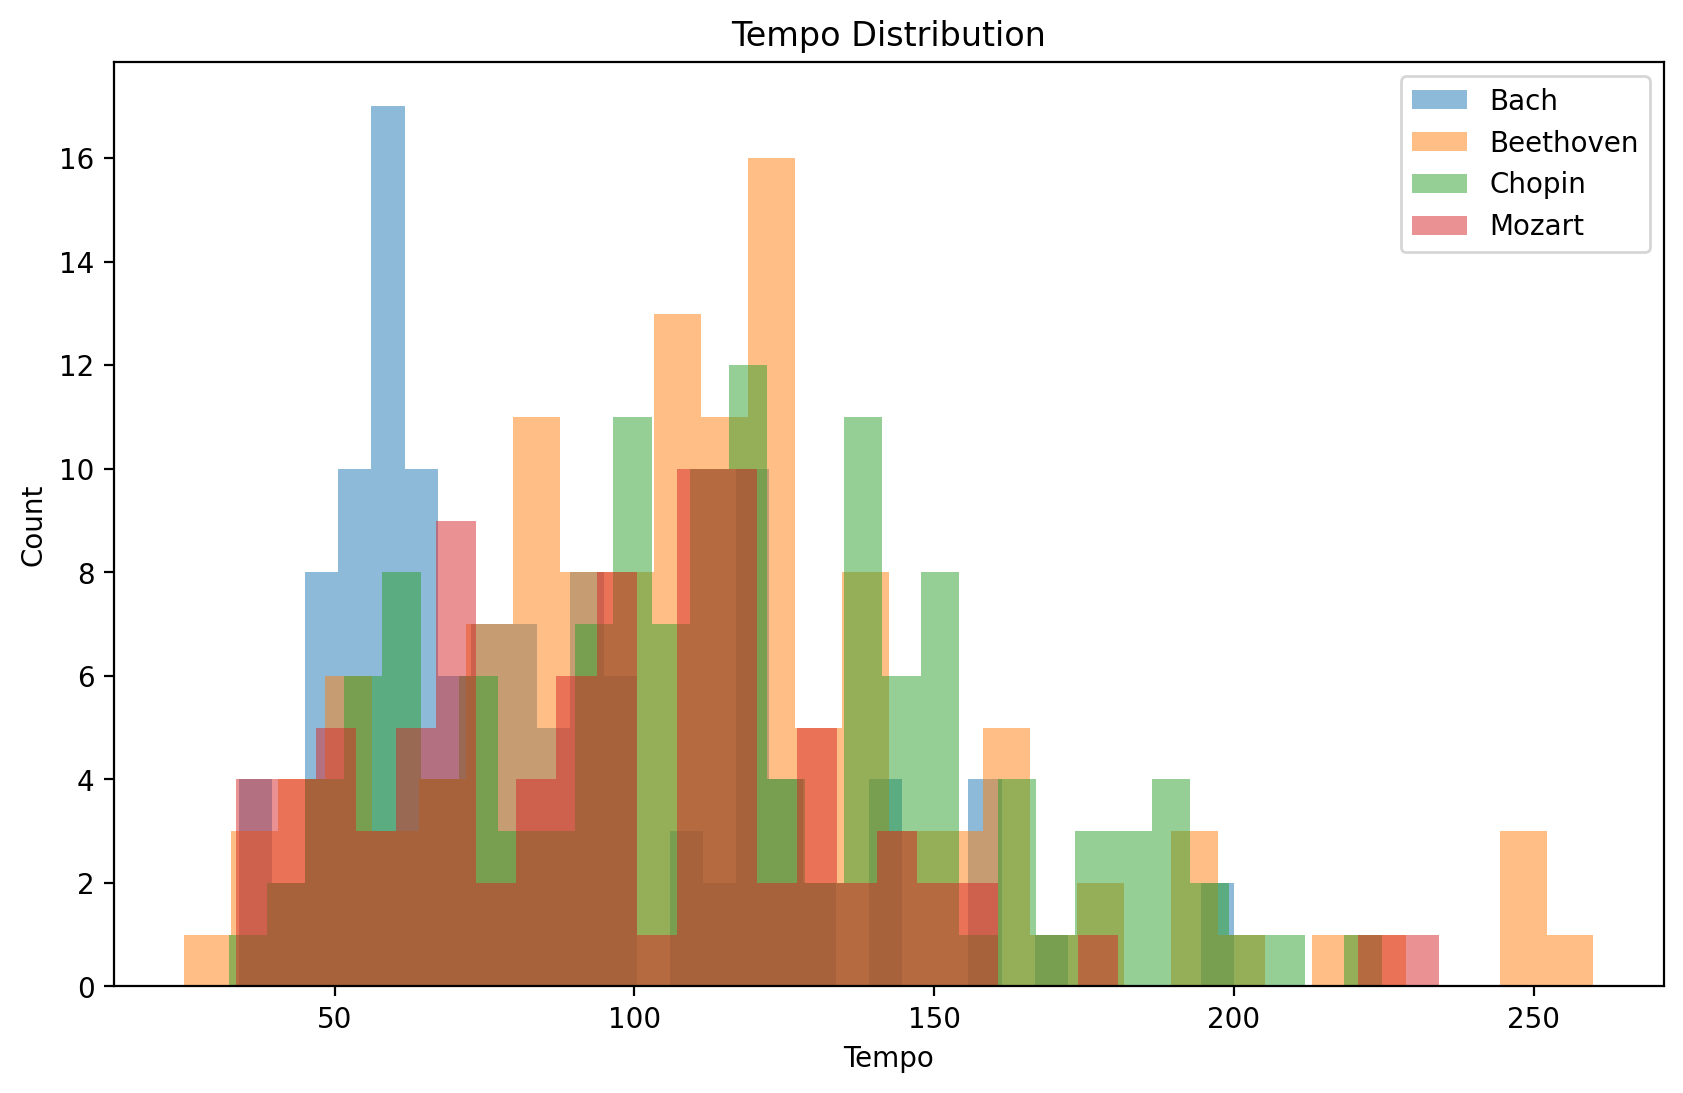

In [57]:
# utils_ppatel.py
# Visualized after feature extraction 
utils.plot_tempo_distribution(tempo_f, composer_label)

### Figure 2 - Pitch Mean Distributions

Mean pitch shows small but consistent differences. Beethoven and Mozart lean towards higher pitches, while Bach and Chopin are slightly lower. Overlapping distributions suggest that pitch is useful but only when paired with other musical features.

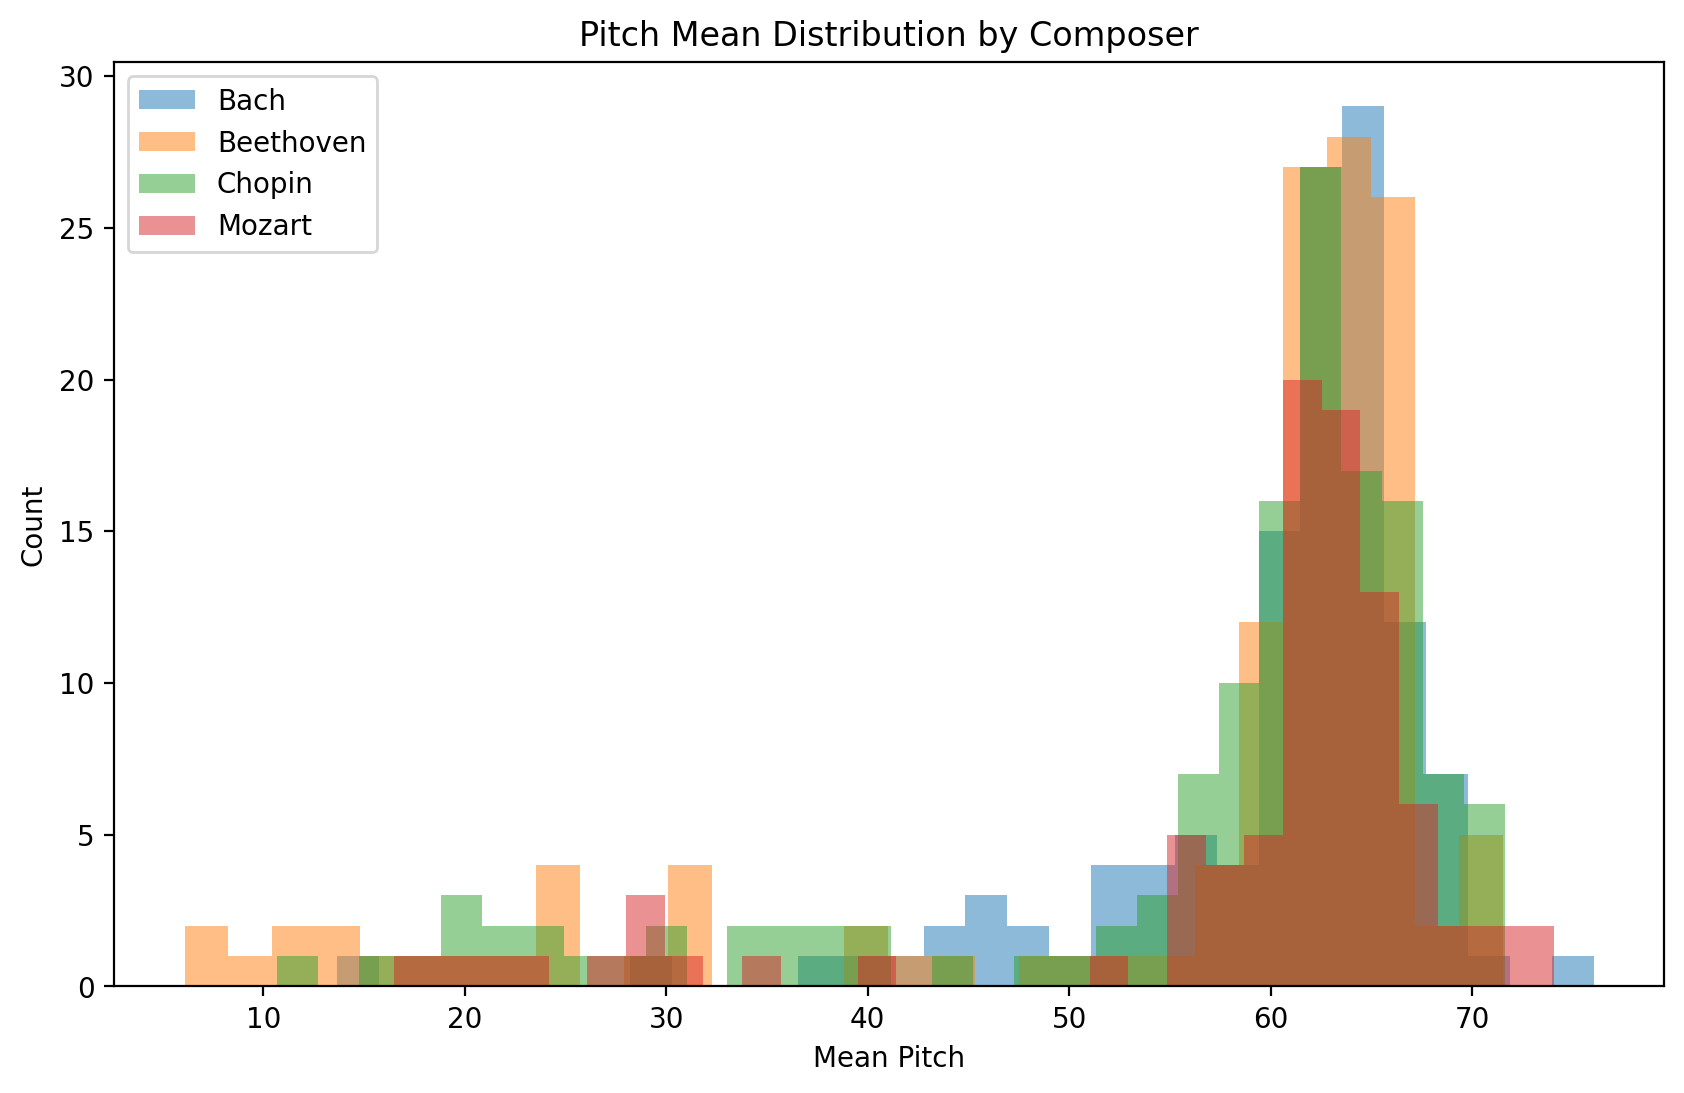

In [58]:
utils.plot_pitch_distribution(note_f, composer_label)

### Figure 3 - Velocity Mean Distribution

Bach's compositions show higher average velocities compared to other composers, this indicates that velocity may be a strong feature to differentiate compositional styles.

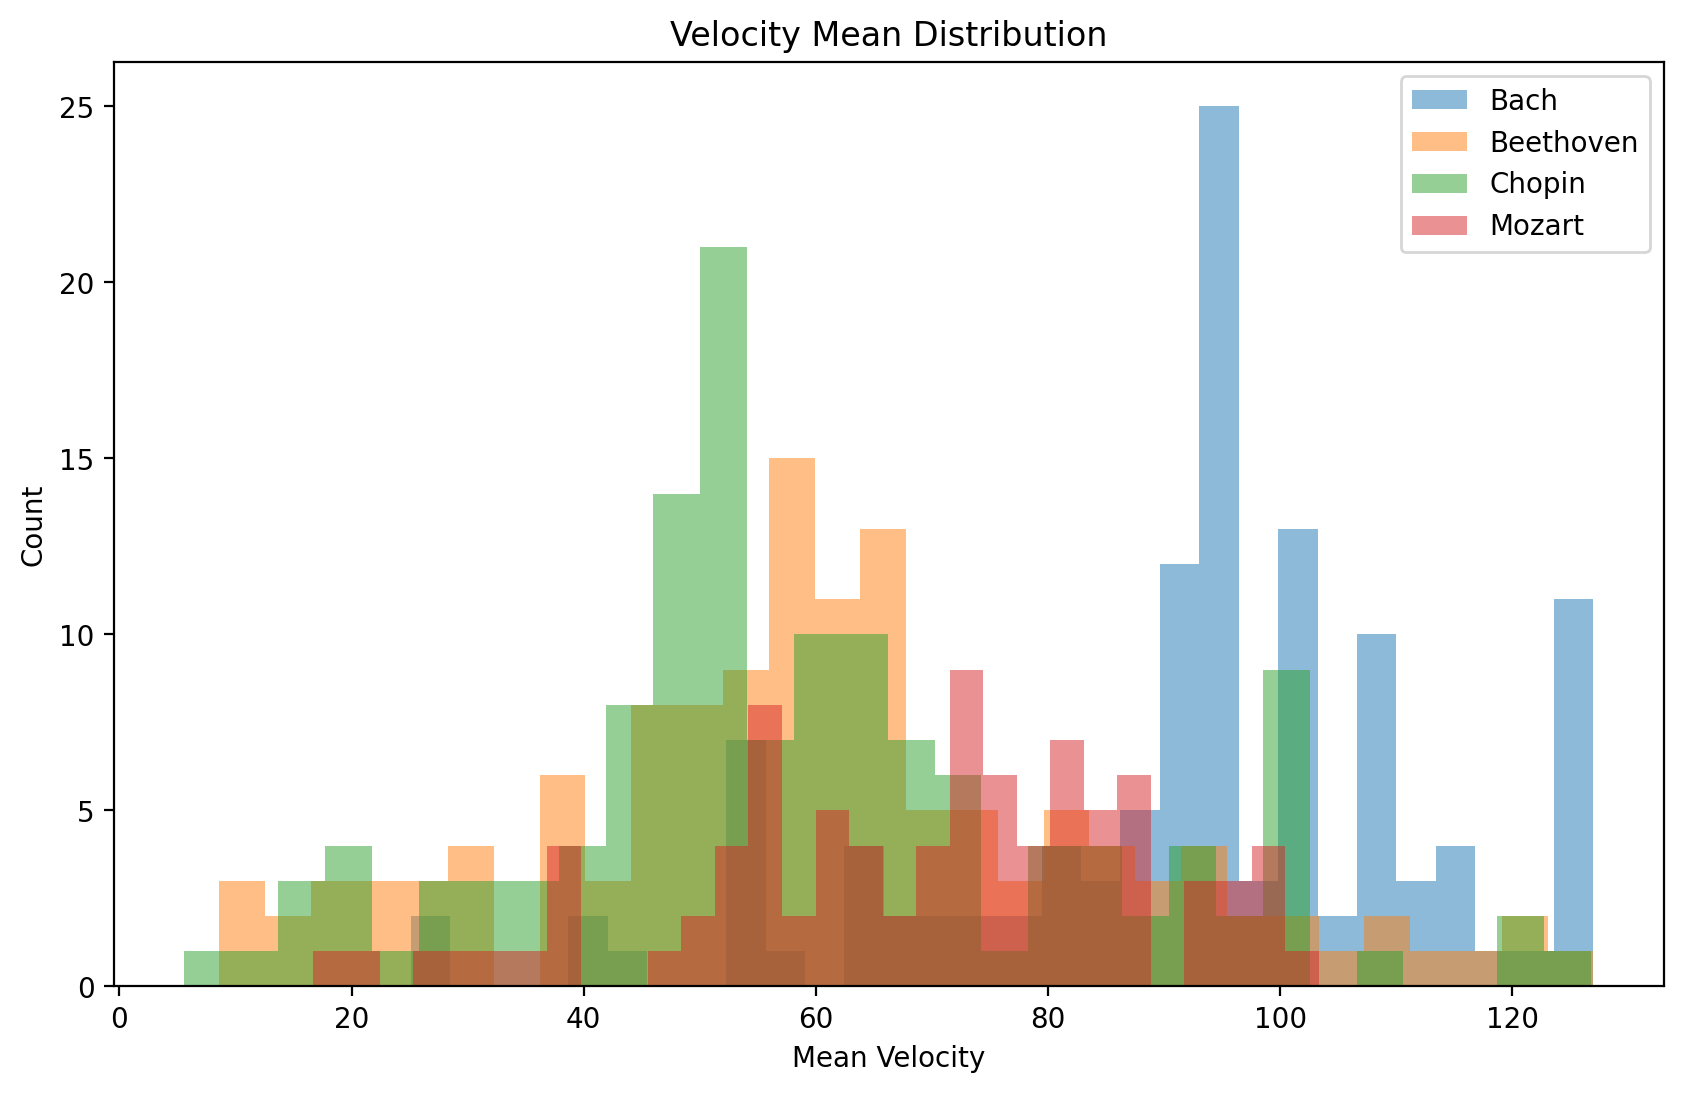

In [59]:
utils.plot_velocity_distribution(note_f, composer_label)

### Figure 4 - Time Mean Distribution

Most pieces have very short mean times, with Chopin and Bach showing the highest concentration near zero. Beethoven and Mozart spread out slightly wider (only few pieces with a longer duration). Since time is skewed, a log transform could potentially help.

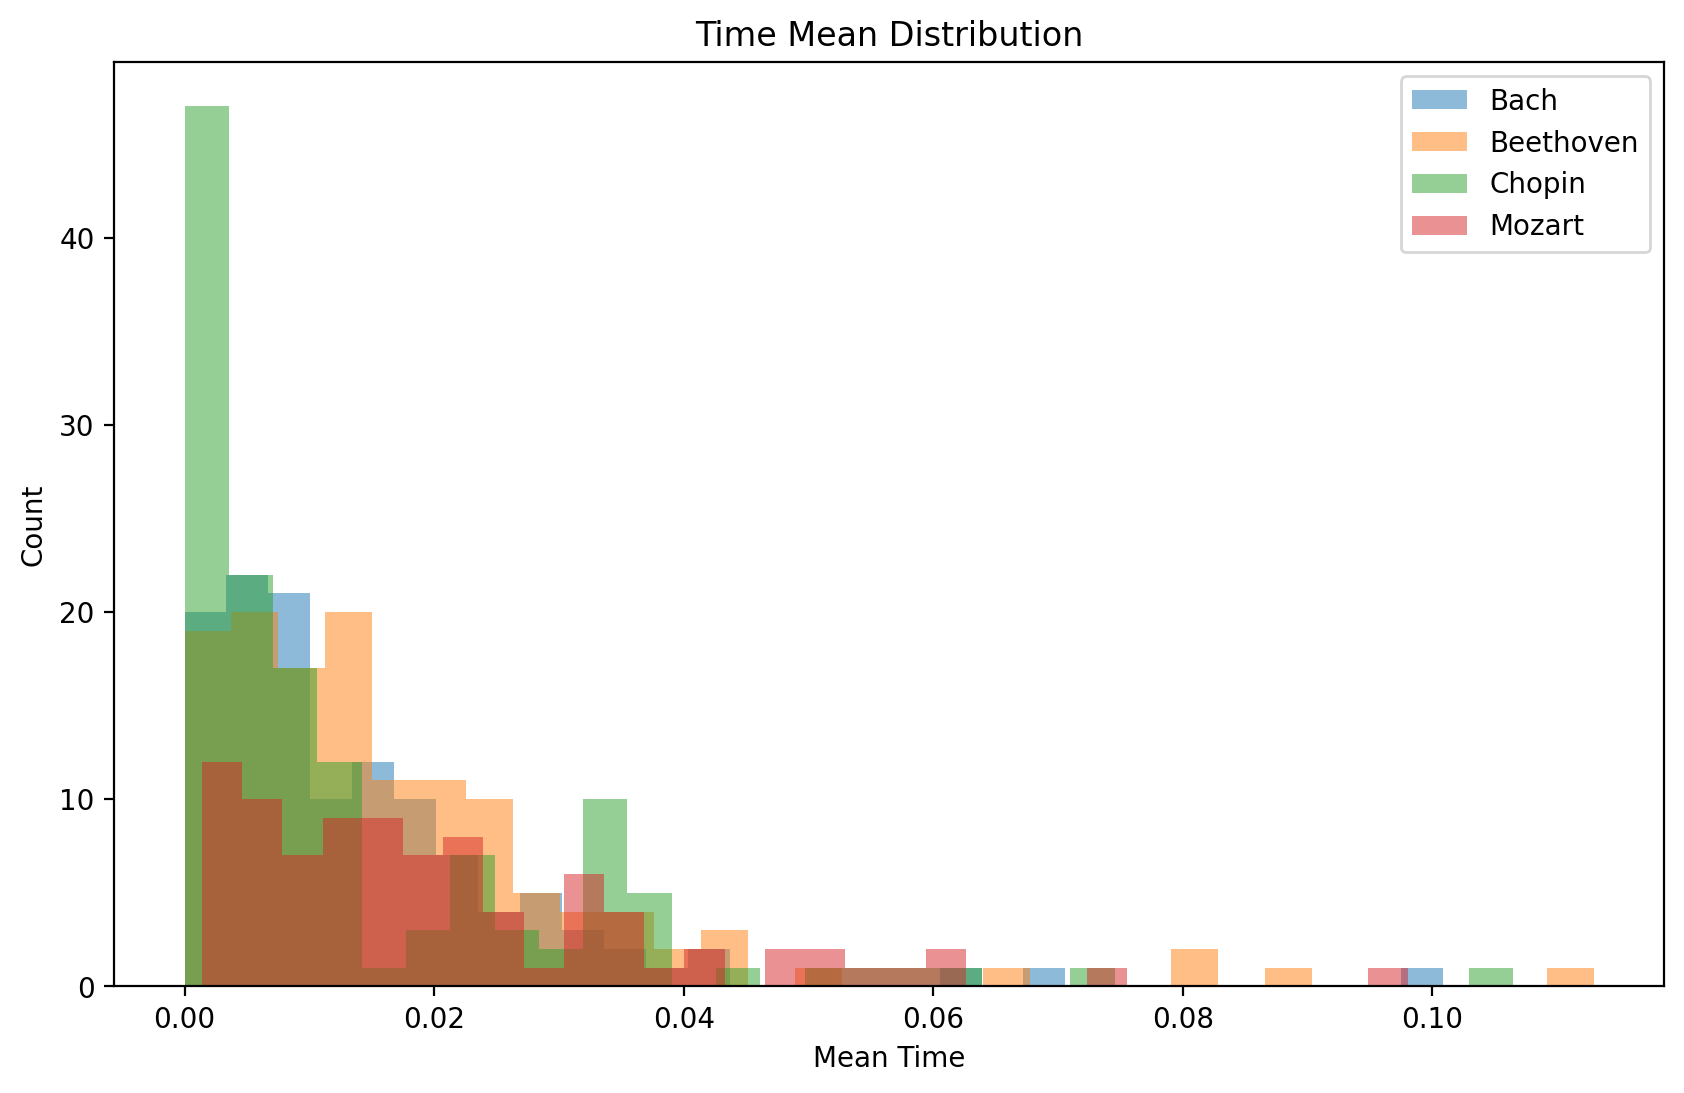

In [60]:
utils.plot_time_distribution(note_f, composer_label)

## 4.2 Data Preparation

We started by normalizing the extracted features using a StandardScaler to ensure all features are on the same scale. The dataset is then split into training and testing sets using a 80/20 split. Next, the NumPy arrays were converted into PyTorch tensors and organized into TensorDatasets. Finally, DataLoaders were created for batching during model training.

To address class imbalance, we also experimented with data augmentation techniques. For this specific approach, we tried stretching the music pieces in classes with fewer samples to increase their size. We also attempted to oversample the minority classes to balance the dataset. Additionally, after analyzing the time mean histogram, we thought it would be a good idea to apply a log transform to reduce skewness. However, none of these approaches improved the model's performance, potentially due to subtle differences in timing and overlapping. Therefore we decided to exclude them from this model apporach.

## 4.3 Initialize Model

For initialization, we define a CNN-BiLSTM model with attention to classify the composers based on MIDI features. To address class imbalance, we computed class weights from the training labels and incorporated them into the CrossEntropyLoss criterion. We also tested using focal loss as an alternative loss function to focus training on samples that are harder to classify, but this resulted in decreased overall accuracy. The model and criterion are moved to GPU, and the Adam optimizer is initalized with a learning rate of 0.001.

In [61]:
# utils_ppatel.py
# Data prep
train_load, test_load, _, _, _, _ = utils.prepare_data(X_full, y_full, batch_size=32)

# Model initialization
model, criterion, optimizer = utils.get_model(
    input_feature=X_full.shape[1],
    num_classes=len(utils.TARGET_COMPOSERS),
    labels=y_full,
    device=utils.gpu_device)


## 4.4 Model Architecture

This model combines convolutional layers, bidirectional LSTM, and an attention method to classify composers based on the feature extraction done using Mido and PrettyMidi.

Attention
- Helps the model focus on relevant points of a sequence output by the LSTM.
- Computes attention scores for each time step using a linear layer.
- Scores were normalized using softmax.
- Reduces noise.

CNN Layers
- This model uses three 1D convolutional layers with filter sizes of 32, 64, and 256.
- Each convolution is then followed by batch normalization, ReLU activation, dropout for regularization, and max pooling. 

Bidirectional LSTM (BiLSTM)
- BiLSTM is what processes the CNN features to capture temporal information from the entire sequence.

Model's Overall Forward Function
- Input tensor is reshaped, then passed through the CNN layers.
- CNN output is rearranged to fit the LSTM's input
- BiLSTM then processes this sequence data.
- Attention is applied to identify the most important parts of the LSTM output.
- Dropout is applied to reduce overfitting before the final layer predicts the composer. 

This model combines CNNs to find patterns and BiLSTM with attention to understand the sequence, essentially helping it classify the music more accurately.


In [62]:
# utils_ppatel.py
# Attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        # Compute attention scores - linear
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # Compute attention score for each time
        score = self.attention(encoder_outputs)  
        # Normalize scores to weights - softmax
        attn_weights = torch.softmax(score, dim=1)  
        # Sum of encoder output using the attention weights
        context_vector = torch.sum(attn_weights * encoder_outputs, dim=1)  
        return context_vector, attn_weights

class ComposerCNNBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.1):
        super(ComposerCNNBiLSTMWithAttention, self).__init__()
        # CNN layers
        self.cnn_layer = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob),

            nn.Conv1d(64, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob)
        )
        # Bidirectional LSTM 
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, batch_first=True, bidirectional=True)

        # Attention method
        self.attention = Attention(hidden_dim=256*2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(256*2, num_classes)
    
    # Rearrange, CNN output, dimension
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.cnn_layer(x)  
        x = x.permute(0, 2, 1) 

        lstm_out, _ = self.lstm(x)  

        # Apply attention 
        attn_out, attn_weights = self.attention(lstm_out)  
        out = self.dropout(attn_out)
        out = self.fc(out)
        return out

## 4.5 Training and Evaluation

### Training
During the training process, we experimented with several hyperparameters to improve model performance. We adjusted the learning batch size, learning rate, and epochs to find a good balance between training speed and accuracy. 

We also tested various dropout probabilities to reduce overfitting, noticing that a dropout of about 0.1 improved generalization. Additionally, the architecture's CNN kernel sizes and LSTM hidden units were explored to better capture temporal features from the data.

Despite these efforts, some hyperparameter changes, like increasing batch size or lower epoches <100 and >120, decreased overall performance. These attempts at tuning helped refine this approach, however, out of the approaches we tried, it was not the best one (we will discuss the best one further down).

### Evaluation

The model approach achieved an overall accuracy of 67.7%, indicating moderate capability in identifying between the four composers. 

#### Confusion Matrix Analysis

- Bach was predicted correct with 22 out of 25 samples classfied.
- Beethoven showed the lowest recall (50%), with missclassifications across other classes, suggesting it is the most difficult class for the model.
- Chopin achieved a balanced precision and recall (71-74%%), indicating that the model is consistent.
- Mozart had high precision (73%) but lower recall (72%), suggesting false negatives.

#### Classification Report Summary

- The macro average F1-score of about 0.66 suggests moderately balanced performance across classes.
- The model performs best on Bach and Chopin pieces but struggles differentiating between Beethoven and Mozart.

In addition to the evaluation, it is important to note that the feature extraction, using both mido and prettyMIDI, may have played a role in the model's performance. Despite hyperparameter tuning and optimization, the overlap in muscial features between composers were a challenge for classification. Overall, the model highlights moderate results, but distinguishing between certain composers poses a challenge for this model. 

Note: Though other model approaches in this project use the same baseline CNN-BiLSTM model, they do not use mido for feature extraction, which may be a contributing factor to differences in performance. 

Epoch 1/120, Loss: 1.0574
Epoch 2/120, Loss: 1.0341
Epoch 3/120, Loss: 1.0282
Epoch 4/120, Loss: 0.9693
Epoch 5/120, Loss: 0.9129
Epoch 6/120, Loss: 0.9283
Epoch 7/120, Loss: 1.0030
Epoch 8/120, Loss: 0.8886
Epoch 9/120, Loss: 0.8411
Epoch 10/120, Loss: 0.8408
Epoch 11/120, Loss: 0.8430
Epoch 12/120, Loss: 0.8005
Epoch 13/120, Loss: 0.7518
Epoch 14/120, Loss: 0.6955
Epoch 15/120, Loss: 0.6953
Epoch 16/120, Loss: 0.7132
Epoch 17/120, Loss: 0.6302
Epoch 18/120, Loss: 0.5894
Epoch 19/120, Loss: 0.6345
Epoch 20/120, Loss: 0.6218
Epoch 21/120, Loss: 0.6771
Epoch 22/120, Loss: 0.6527
Epoch 23/120, Loss: 0.6147
Epoch 24/120, Loss: 0.5522
Epoch 25/120, Loss: 0.5557
Epoch 26/120, Loss: 0.4881
Epoch 27/120, Loss: 0.4731
Epoch 28/120, Loss: 0.4312
Epoch 29/120, Loss: 0.3958
Epoch 30/120, Loss: 0.4151
Epoch 31/120, Loss: 0.3848
Epoch 32/120, Loss: 0.3621
Epoch 33/120, Loss: 0.3599
Epoch 34/120, Loss: 0.4194
Epoch 35/120, Loss: 0.4404
Epoch 36/120, Loss: 0.3820
Epoch 37/120, Loss: 0.3791
Epoch 38/1

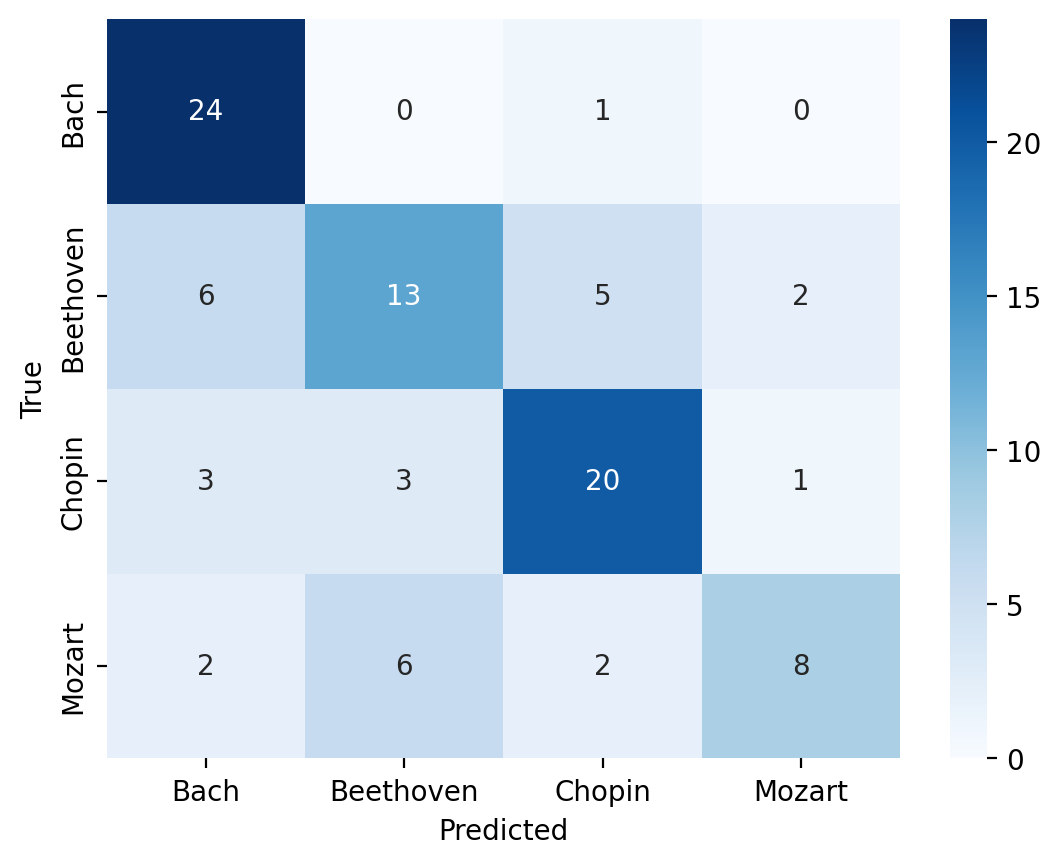

In [64]:
# utils_ppatel.py
utils.train_and_evaluate(
    model=model,
    train_load=train_load,
    test_load=test_load,
    criterion=criterion,
    optimizer=optimizer,
    device=utils.gpu_device,
    le=le,
    num_epochs=120
)

# 5. Model B - CNN-BiLSTM Composer Classification

## 5.1 Data Processing and Augmentation


This is our CNN-BiLSTM approach that only utilized PrettyMIDI and mainly the piano roll features. Some differences in the way the data was preprocessed for this model:

    - A stratified train-split method was implemented to combat the class imbalance

    - Processing included some data augmentation (pitch shifting and velocity jitter) specifically for underrepresented classes to improve the model's predictions for those classes

    - WeightRandomSampler and class-weighted loss methods were also implemented to combat the class imbalance in the dataset

## 5.2 Model Architecture and Evaluation
- **CNN**: Processes piano roll data for visual pattern recognition
- **BiLSTM**: Models temporal relationships in both forward and backward directions
- **Attention Mechanism**: Learns to focus on most relevant time steps in the sequence

In [ ]:
# utils_Sean.py
class CNNBiLSTMAttentionClassifier2(nn.Module):
    def __init__(self, input_size=256, num_classes=4, dropout_p=0.4, lstm_hidden=256):
        super().__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, None))  
        )

        self.dropout_cnn = nn.Dropout(dropout_p)

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_hidden,
            num_layers=2,
            bidirectional=True,
            dropout=dropout_p,
            batch_first=True
        )

        # Attention layer (tanh for sharper focus)
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(lstm_hidden * 2),
            nn.Linear(lstm_hidden * 2, 128),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.dropout_cnn(x)
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)

        attn_weights = self.attention(lstm_out)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        return self.classifier(context)

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              95.6%       0.5%       0.0%       3.9%
Beethoven         27.9%      30.2%      20.9%      20.9%
Chopin             7.4%      29.6%      51.9%      11.1%
Mozart            17.6%      17.6%       2.0%      62.7%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.8950    0.9561    0.9245       205
   Beethoven     0.4194    0.3023    0.3514        43
      Chopin     0.5833    0.5185    0.5490        27
      Mozart     0.6154    0.6275    0.6214        51

    accuracy                         0.7822       326
   macro avg     0.6283    0.6011    0.6116       326
weighted avg     0.7627    0.7822    0.7704       326

Validation Accuracy: 0.7822


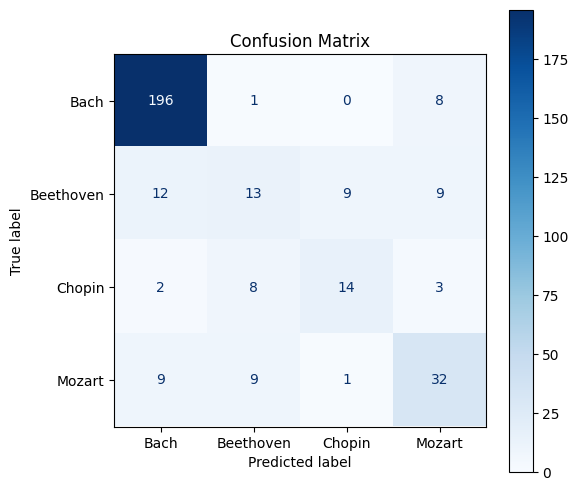

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              77.6%      10.2%       1.5%      10.7%
Beethoven         16.3%      58.1%      11.6%      14.0%
Chopin             0.0%      37.0%      59.3%       3.7%
Mozart             3.9%      56.9%       3.9%      35.3%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.9464    0.7756    0.8525       205
   Beethoven     0.2941    0.5814    0.3906        43
      Chopin     0.6154    0.5926    0.6038        27
      Mozart     0.3830    0.3529    0.3673        51

    accuracy                         0.6687       326
   macro avg     0.5597    0.5756    0.5536       326
weighted avg     0.7448    0.6687    0.6951       326

Validation Accuracy: 0.6687


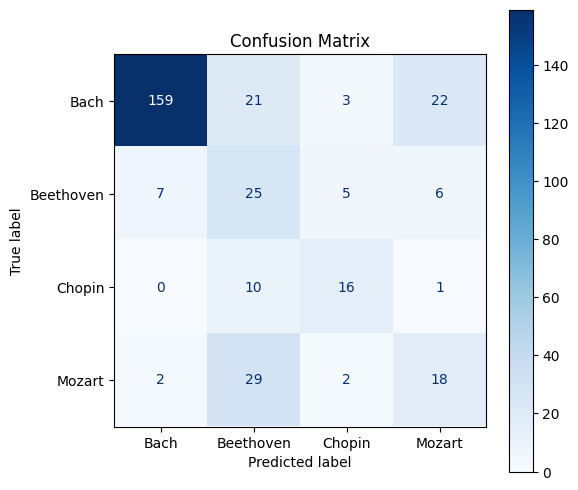

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              88.8%       5.9%       1.0%       4.4%
Beethoven         18.6%      58.1%       7.0%      16.3%
Chopin             0.0%      22.2%      55.6%      22.2%
Mozart            11.8%      23.5%       7.8%      56.9%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.9286    0.8878    0.9077       205
   Beethoven     0.4545    0.5814    0.5102        43
      Chopin     0.6250    0.5556    0.5882        27
      Mozart     0.5686    0.5686    0.5686        51

    accuracy                         0.7699       326
   macro avg     0.6442    0.6483    0.6437       326
weighted avg     0.7846    0.7699    0.7758       326

Validation Accuracy: 0.7699


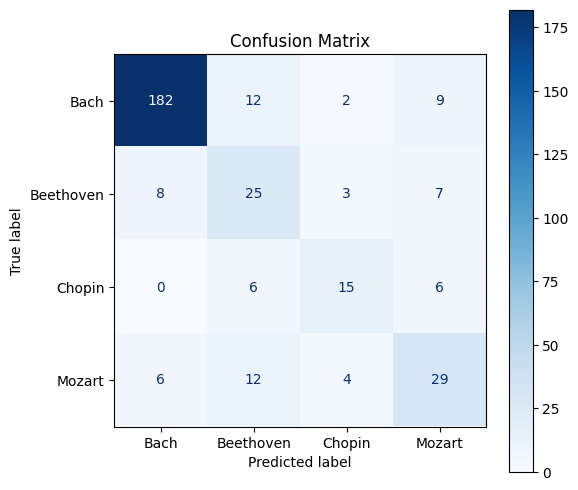

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              93.7%       0.5%       3.4%       2.4%
Beethoven         34.9%      25.6%      20.9%      18.6%
Chopin             7.4%       3.7%      81.5%       7.4%
Mozart            21.6%      15.7%      21.6%      41.2%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.8727    0.9366    0.9035       205
   Beethoven     0.5238    0.2558    0.3438        43
      Chopin     0.4490    0.8148    0.5789        27
      Mozart     0.5833    0.4118    0.4828        51

    accuracy                         0.7546       326
   macro avg     0.6072    0.6047    0.5772       326
weighted avg     0.7463    0.7546    0.7370       326

Validation Accuracy: 0.7546


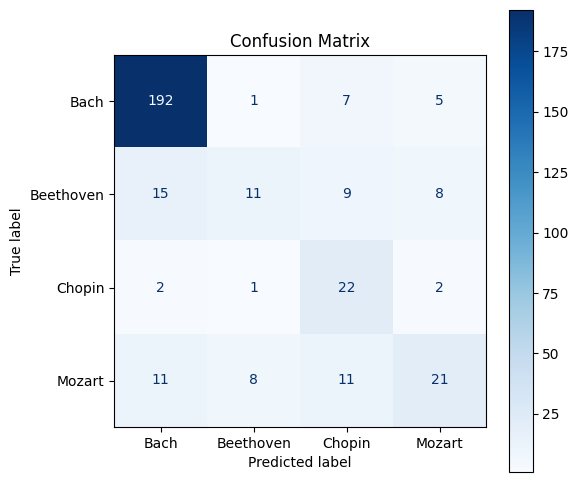

In [ ]:
# Cell from AAI511_Final_Project (Sean).ipynb showing different model iterations
class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

evaluate_confusion_matrix(model1, val_loader, device, class_names)
evaluate_confusion_matrix(model2, val_loader, device, class_names)
evaluate_confusion_matrix(model3, val_loader, device, class_names)
evaluate_confusion_matrix(model4, val_loader, device, class_names)

## 5.3 Summary of CNN-BiLSTM model
While the model was able to have a fairly high accuracy/f1-score (around 70-80%), it still struggled with any composer that wasn't Bach. This could still be a result of how imbalanced the dataset was. Future improvements for this iteration of the model could include:

* Adding/Improving features such as spectogram features

* Model architecture improvements such as multi-branching

* Potentially creating models that are specialized in identifying each composer and then having them work in an ensemble approach

# 6. Model C - CNN-MLP Multimodal Composer Classification

Upon reading the course slack messages, and seeing that some students reported good results when creating separate CNN and LSTM models, then ensembling them, this model was created to replicate that attempt. Apart from passing the piano roll through convolutional layers like before, this model also introduced separate MLP (Multilayer Perceptron) layers to learn from features that were engineering by extracting musical features from the piano_roll data. This way, the model can mimic the multi-modality described in the [youtube video](https://youtube.com/shorts/AQrRfqEVpic?si=ihqV33mBX9kqla07) mentioned earlier.

## 6.1 Model Architecture
- **CNN Stream**: Processes piano roll data for visual pattern recognition
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines both streams for final classification

In [ ]:
# %pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=b1749eaff8b99bb58cfcccc8eb0d3253865bf586e5a7390b6681ff435db5abd2
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


We'll download the dataset and start from scratch like before

In [6]:
# download dataset
paths = download_dataset()

Dataset downloaded and extracted to data/kaggle/midiclassics


## 6.2 Loading Piano Rolls

For this particular model, in order to prepare the piano roll data, the `load_segmented_dataset_no_overlap` function was created.
It uses pretty_midi to load and process MIDI files for each target composer. The function performs the following steps:

1. MIDI Loading and Segmentation:
For each MIDI file, it uses pretty_midi to extract the full piano roll and then splits the music into non-overlapping segments of a specified duration (e.g., 20 seconds). This segmentation increases the number of training samples and ensures that each segment is a distinct, contiguous part of the music.

2. Piano Roll Extraction and Normalization:
Each segment is converted into a piano roll matrix (notes × time) using pretty_midi, and normalization is applied to standardize the data (such as focusing on the active pitch range).

3. Feature Extraction:
For every segment, the function computes a set of musical features (e.g., note density, pitch range, rhythmic patterns) that can be used for multi-modal or feature-based models.

4. Quality Filtering:
Segments that are too sparse (with very few notes) are filtered out to ensure only musically meaningful data is included.

5. Class Balancing (Song-aware):
The function balances the number of segments per composer by either downsampling or oversampling at the song level. This ensures that all segments from a single song are kept together in either the training or validation set, preventing data leakage.

6. Caching:
The processed dataset is cached to disk for faster loading in future runs. If the cache exists, it loads the data directly from cache.

### Output:
The function returns:

- data: numpy array of piano roll segments (samples × notes × time)
- labels: numpy array of integer labels (composer indices)
- features: list of feature dictionaries for each segment
- song_ids: list of unique identifiers for each segment (song and segment index)

### In summary:
`load_segmented_dataset_no_overlap` uses pretty_midi to segment, normalize, extract features, filter, balance, and cache a dataset of MIDI files, returning arrays and features ready for machine learning and deep learning experiments.

In [19]:
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)

LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True
Loading segmented dataset from cache: ../local_cache/segmented_dataset_no_overlap_20.0.pkl


In [20]:
song_ids[0:5] # For example: ['Bach_0_0', 'Bach_0_1', 'Bach_0_2', 'Bach_0_3', 'Bach_0_4']

['data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__0',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__1',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__2',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__3',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__4']

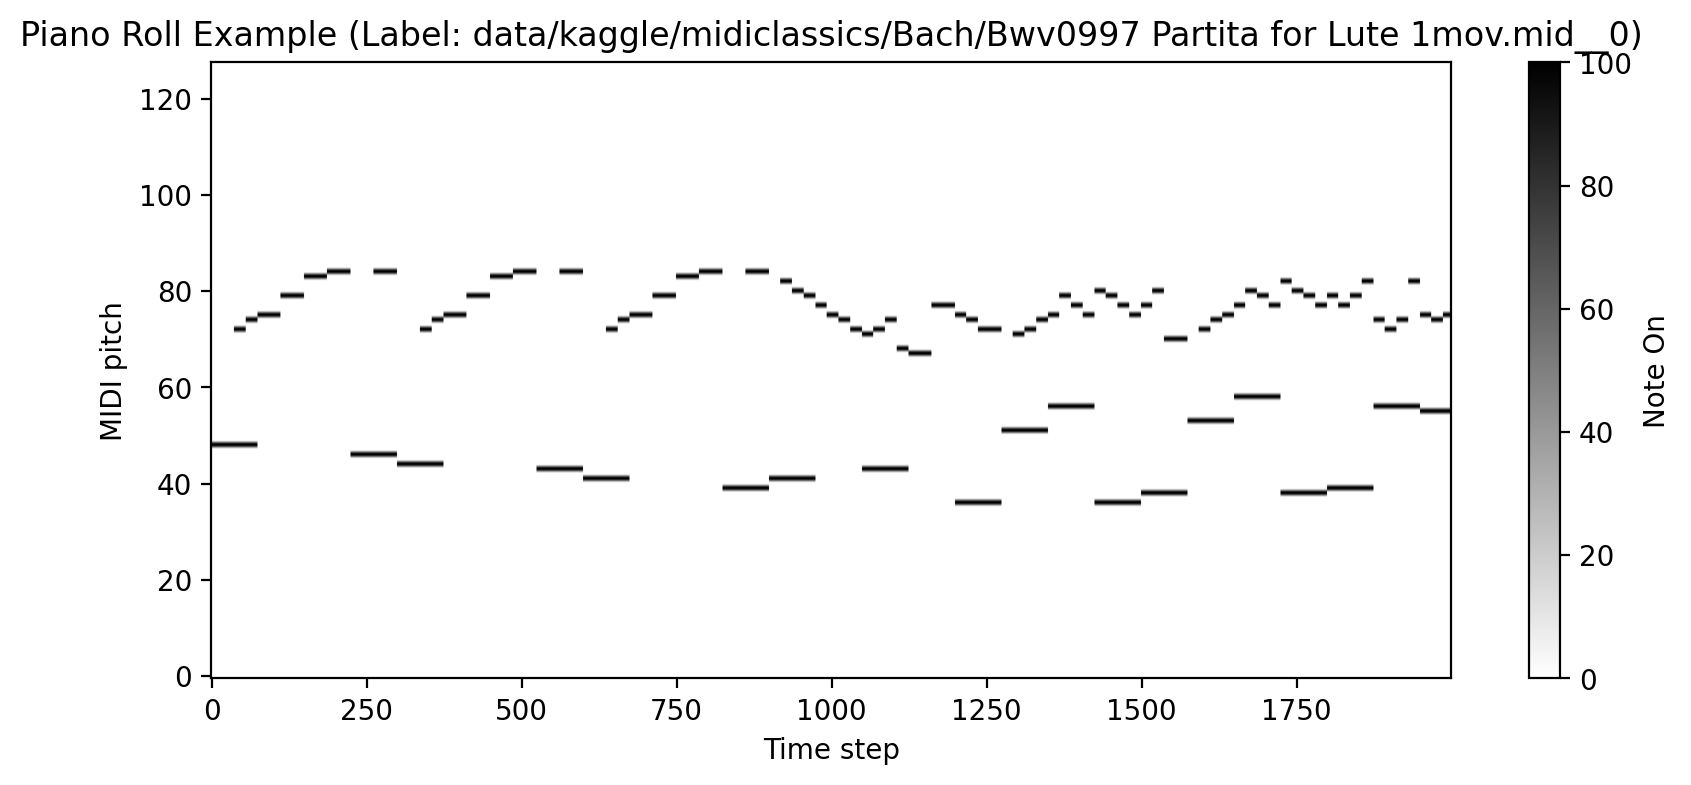

In [24]:
# plot the piano roll for the first song
plt.figure(figsize=(10, 4))
plt.imshow(data[0], aspect='auto', origin='lower', cmap='gray_r')
plt.xlabel("Time step")
plt.ylabel("MIDI pitch")
plt.title(f"Piano Roll Example (Label: {song_ids[0]})")
plt.colorbar(label='Note On')
plt.show()

## 6.3 Loading Engineered Features
In order to add multimodality to the model, part of the network will process musical features extracted from each file. The aim is to have features that have statistical significance and have the network associate them with certain convolutional patterns.


The load `load_comprehensive_features` function uses `extract_comprehensive_musical_features` internally to generate a detailed, normalized feature vector for each piano roll, capturing temporal, harmonic, dynamic, and stylistic aspects of the music. This enables more interpretable and multi-modal machine learning models. It works as follows:

- Caching:
To speed up training. If we've computed these features before, pull them from a file. Else, after computing the features, it saves them.

- Feature Extraction:
It computes features for each piano roll by calling the `extract_comprehensive_musical_features` function. The results are then cached for future use.

### Features Extracted by extract_comprehensive_musical_features
For each piano roll, the following features are extracted:

#### Temporal/Rhythmic Features

- `avg_notes_per_time`: Average number of notes played per time step.
- `note_density_variance`: Variance of note density over time.
- `note_density_std`: Standard deviation of note density over time.
- `max_simultaneous_notes`: Maximum number of notes played at once.
- `onset_density`: Frequency of new note onsets.
- `silence_ratio`: Fraction of time steps with no notes played.
- `temporal_sparsity`: Proportion of time steps with no activity.
- `activity_bursts`: Frequency of bursts of musical activity.


#### Pitch/Harmonic Features

- `pitch_range`: Number of unique pitches used.
- `lowest_pitch`: Lowest pitch played.
- `highest_pitch`: Highest pitch played.
- `pitch_span`: Difference between highest and lowest pitch.
- `pitch_centroid`: Weighted average pitch (center of gravity).
- `pitch_variance`: Variance of pitch activity.
- `bass_activity`: Fraction of notes in the bass register (A0–B2).
- `mid_activity`: Fraction of notes in the mid register (C3–B4).
- `treble_activity`: Fraction of notes in the treble register (C5–B7).


#### Other Harmonic Features

- `chord_ratio`: Fraction of time steps with chords (3+ notes).
- `single_note_ratio`: Fraction of time steps with only one note.
- `polyphony_complexity`: Average number of notes played when there is activity.
- `avg_chord_size`: Average number of notes in a chord.
- `chord_variance`: Variance in chord sizes.


#### Velocity/Dynamics Features

- `avg_velocity`: Average note velocity (intensity).
- `velocity_variance`: Variance of note velocities.
- `velocity_range`: Range of velocities.
- `dynamic_complexity`: Diversity of velocities used.


#### Style-Specific Features

- `overall_density`: Fraction of the piano roll that is active (notes played).
- `rhythmic_regularity`: Inverse of note density variance (higher means more regular rhythm).
- `pitch_movement_variance`: Variance in the movement of pitch centers over time.
- `melodic_direction_changes`: Frequency of changes in melodic direction.

Our feature extraction approach is aligned with established practices in Music Information Retrieval (MIR) and related pattern recognition tasks, where the goal is to capture multiple aspects of the signal through diverse features. As noted in Dell’Aversana et al. (2016):

> “Pattern recognition is commonly based on the extraction of several features from the data. A feature is a specific piece of information that can be used for characterizing the data itself.” (p. 414)

MIR research commonly groups musical features into categories that match the design of `extract_comprehensive_musical_features`:

> “Musical features typically fall into one of three main categories: low-level, high-level and cultural features. Spectral or time-domain information… belong to the first category. Melodic contour, chord frequencies and rhythmic properties are typical examples of high-level features.” (p. 414)

A major benefit of symbolic formats such as MIDI is their ability to store richer descriptors:

> “Many new attributes can be introduced… after transforming… into MIDI format… symbolic representations… can store high-level musical information… rhythmic, melodic and harmonic patterns, chord sequences and other significant structures.” (p. 417)

Empirical results show that including such high-level, polyphonic features improves classification outcomes:

> “When also ‘high-level’ MIDI features are included (such as rhythmic, melodic and harmonic multi-valued features), the classification performance improves in terms of cluster separation.” (p. 425)

By incorporating temporal, harmonic, dynamic, and stylistic descriptors, our feature set follows the same principle: using a broad, multi-level representation to improve the interpretability and performance of downstream machine learning models.



### References

Dell’Aversana, P., Gabbriellini, G., Marini, A. I., & Amendola, A. (2016). Application of Musical Information Retrieval (MIR) techniques to seismic facies classification: Examples in hydrocarbon exploration. *AIMS Geosciences, 2*(4), 413–425. https://doi.org/10.3934/geosci.2016.4.413

In [ ]:
# gets the extracted features for multi-modal learning
comprehensive_features = load_comprehensive_features(data)

✅ Saved comprehensive_features to cache: local_cache/comprehensive_musical_features.pkl


In [13]:
num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])

num_classes, num_features

(4, 30)

Once again, there were multiple iterations of this model, but this was the one that gave us the best result. Among the various attemps, we also tried leakyReLU, but ReLU performed better.

In [ ]:
class MultimodalComposerClassifier(nn.Module):
    """
    Multimodal architecture combining CNN (piano rolls) + MLP (musical features)
    """
    def __init__(self, num_classes=4, num_features=None):
        super(MultimodalComposerClassifier, self).__init__()

        # CNN Stream for Piano Rolls (visual patterns)
        self.cnn_stream = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), # <--- we also tried LeakyReLU, given that piano rolls are sparse, but ReLU worked better
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Global pooling instead of LSTM
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # MLP Stream for Musical Features (hand-crafted features)
        self.mlp_stream = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Fusion Layer (combine both streams)
        self.fusion = nn.Sequential(
            nn.Linear(128 + 32, 256),  # 128 from CNN + 32 from MLP
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features):
        cnn_features = self.cnn_stream(piano_roll) # piano rolls go through CNN
        mlp_features = self.mlp_stream(features) # hand-crafted features go through MLP
        combined = torch.cat([cnn_features, mlp_features], dim=1) # we put the outputs together for multimodality
        output = self.fusion(combined) # Now, we fuse the two streams into a final layer and classify
        return output

🏗️ CNN-MLP Model Architecture Defined!
• CNN Stream: Processes piano roll visual patterns
• MLP Stream: Processes hand-crafted musical features
• Fusion Layer: Combines both streams for classification


In [ ]:
def train_cnn_mlp_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, device='cpu'):
    """
    Train the CNN-MLP multimodal model

    Args:
        model: CNN-MLP model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs (int): Number of epochs to train
        device (str): Device to train on

    Returns:
        tuple: (train_losses, val_accuracies)
    """
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        for piano_rolls, features, labels in train_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(piano_rolls, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for piano_rolls, features, labels in val_loader:
                piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
                outputs = model(piano_rolls, features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'[CNN-MLP] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step()

    return train_losses, val_accuracies

print("CNN-MLP training function defined")

✅ CNN-MLP training function defined


Given the computational cost, we have not performed hyperparameter tuning, or explored different optimizers; however, we did tweak the learning rate.

In [14]:
model = MultimodalComposerClassifier(num_classes=num_classes, num_features=num_features).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [15]:
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([7305, 128, 2000])
• Features: torch.Size([7305, 30])
• Labels: torch.Size([7305])
• Total samples: 7305
📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([1827, 128, 2000])
• Features: torch.Size([1827, 30])
• Labels: torch.Size([1827])
• Total samples: 1827
📊 Songwise Data Loaders Created:
• Training samples: 7305
• Validation samples: 1827
• Batch size: 32


In [16]:
EPOCHS = 40
train_losses, val_accuracies = train_cnn_mlp_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=EPOCHS,
    device=device
)

[CNN-MLP] Epoch [1/40], Loss: 1.0743, Val Acc: 65.79%
[CNN-MLP] Epoch [2/40], Loss: 0.8239, Val Acc: 72.19%
[CNN-MLP] Epoch [3/40], Loss: 0.7424, Val Acc: 74.82%
[CNN-MLP] Epoch [4/40], Loss: 0.6899, Val Acc: 77.94%
[CNN-MLP] Epoch [5/40], Loss: 0.6579, Val Acc: 78.98%
[CNN-MLP] Epoch [6/40], Loss: 0.6186, Val Acc: 81.39%
[CNN-MLP] Epoch [7/40], Loss: 0.5987, Val Acc: 82.87%
[CNN-MLP] Epoch [8/40], Loss: 0.5794, Val Acc: 82.70%
[CNN-MLP] Epoch [9/40], Loss: 0.5596, Val Acc: 83.31%
[CNN-MLP] Epoch [10/40], Loss: 0.5407, Val Acc: 83.80%
[CNN-MLP] Epoch [11/40], Loss: 0.5136, Val Acc: 84.78%
[CNN-MLP] Epoch [12/40], Loss: 0.4955, Val Acc: 85.06%
[CNN-MLP] Epoch [13/40], Loss: 0.4953, Val Acc: 85.11%
[CNN-MLP] Epoch [14/40], Loss: 0.4785, Val Acc: 86.43%
[CNN-MLP] Epoch [15/40], Loss: 0.4628, Val Acc: 87.19%
[CNN-MLP] Epoch [16/40], Loss: 0.4463, Val Acc: 86.81%
[CNN-MLP] Epoch [17/40], Loss: 0.4473, Val Acc: 86.86%
[CNN-MLP] Epoch [18/40], Loss: 0.4354, Val Acc: 87.41%
[CNN-MLP] Epoch [19

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9491    0.9147    0.9316       469
   Beethoven     0.8684    0.8665    0.8675       457
      Chopin     0.9342    0.9537    0.9439       432
      Mozart     0.8933    0.9104    0.9018       469

    accuracy                         0.9108      1827
   macro avg     0.9113    0.9113    0.9112      1827
weighted avg     0.9111    0.9108    0.9108      1827



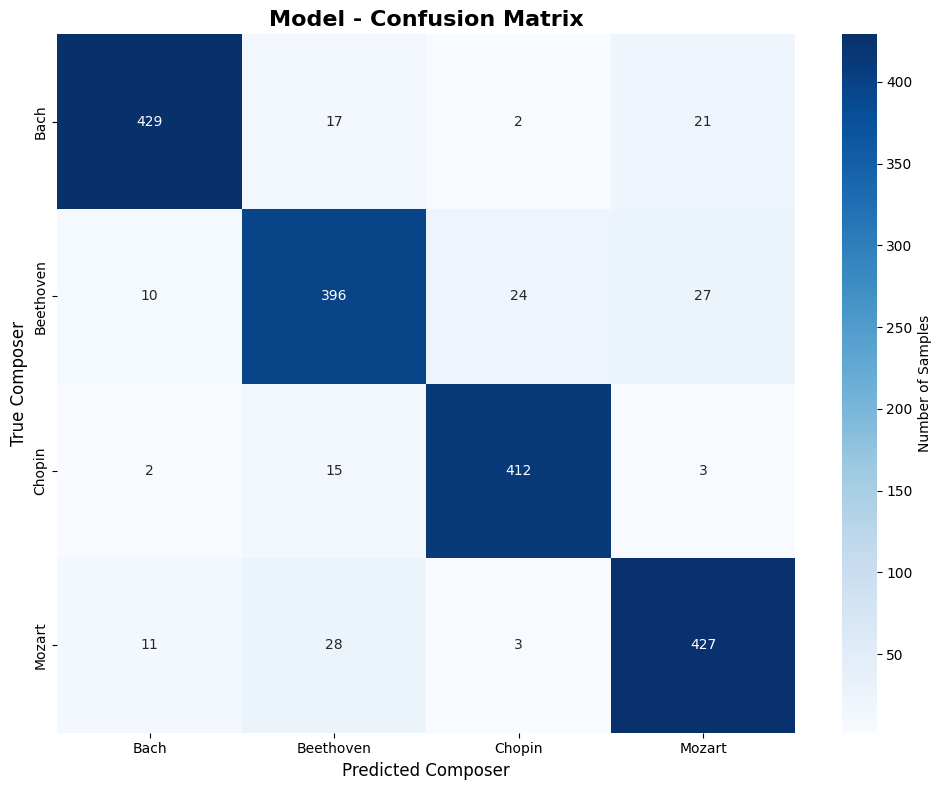


🎯 PER-CLASS ACCURACY:
Bach        : 0.9147 (91.47%)
Beethoven   : 0.8665 (86.65%)
Chopin      : 0.9537 (95.37%)
Mozart      : 0.9104 (91.04%)

🏆 OVERALL ACCURACY: 0.9108 (91.08%)

❌ MOST CONFUSED PAIRS:
Mozart → Beethoven: 28 samples
Beethoven → Mozart: 27 samples
Beethoven → Chopin: 24 samples
Bach → Mozart: 21 samples
Bach → Beethoven: 17 samples


In [17]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [ ]:
# Create the directory if it doesn't exist
save_dir = '../saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'cnn_mlp_composer_classifier.pth'))
print(f"Model saved to {save_dir}!")

✅ Model saved to saved_models!


## 6.4 Summary of CNN-MLP Multimodal Model

The CNN-MLP Multimodal Composer Classifier achieved impressive results by combining convolutional layers for piano roll data with a separate MLP stream for engineered musical features. This multimodal approach allowed the model to leverage both visual patterns and statistical musical features, resulting in an overall **accuracy of 91.08%**.
91.08% overall accuracy on the validation set.


#### Significant Improvement:
This multimodal approach represents a great improvement compared to previous attempts. The best models without multimodality had only achieved accuracies of around 70%, highlighting the value of combining CNNs with engineered features.

#### Potential for Further Optimization:
The evaluation could have been slightly better if the best model state during training (based on validation accuracy) was saved and used for evaluation. Currently, the final model state after all epochs is used, which may not necessarily correspond to the best-performing state. Additionally, we could further refine features and mixin some features obtained through the `music21` library. Some work has yet to be done to identify which features may be the strongest identifiers for our least performing classes and prioritize them.

Nonetheless, this result demonstrates the effectiveness of multimodal learning in composer classification tasks and sets a strong baseline for future experiments.

### Next Steps: Exploring Temporal Relationships

This model did not account for the temporal relationships in the music data. Although the results achieved by this model were very good, exploring more complex architectures that explicitly consider the temporal aspect, such as LSTMs, could further improve performance.

As the next step, we plan to build an LSTM-based model to capture the sequential nature of the music data. The goal is to explore the possibility of using this LSTM model in an ensemble with the current CNN-MLP model, leveraging the strengths of each approach.

# 7. Model C2 - CNN-LSTM-MLP Multimodal Composer Classification

This notebook contains the CNN-LSTM-MLP fusion model architecture and training pipeline for composer classification.

## 7.1 Model Architecture
- **CNN Blocks**: Extracts spatial features from piano rolls
- **LSTM Layer**: Captures temporal dependencies in CNN features
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines LSTM and MLP outputs for final classification

Let's start from scratch again and download the dataset anew

In [ ]:
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)
comprehensive_features = load_comprehensive_features(data)
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True
Loading segmented dataset from cache: ../local_cache/segmented_dataset_no_overlap_20.0.pkl


In [26]:
# Shallow CNN + LSTM (2 CNN layers, 4 LSTM layers, Attention)
class ShallowCNNLSTMClassifier(nn.Module):
    """
    Shallow CNN + LSTM model for piano roll classification.
    - 2 CNN layers for local feature extraction
    - 4-layer LSTM for temporal modeling
    - Attention mechanism after LSTM
    - Optional MLP for hand-crafted features (optional, can be omitted)
    """
    def __init__(self, num_classes=4, num_features=None, lstm_hidden=128, lstm_layers=4):
        super(ShallowCNNLSTMClassifier, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(
            input_size=64*32,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        # Attention mechanism (additive attention)
        self.attn = nn.Linear(lstm_hidden, 1)

        if num_features is not None:
            self.mlp_stream = nn.Sequential(
                nn.Linear(num_features, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.1)
            )
            fusion_input_dim = lstm_hidden + 32
        else:
            self.mlp_stream = None
            fusion_input_dim = lstm_hidden

        # fusion Layer (combine LSTM and MLP outputs)
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features=None):
        # CNN processes piano rolls
        x = self.cnn(piano_roll)  # (batch, 64, 32, T//4)
        batch, channels, height, width = x.shape  # (B, 64, 32, T//4)
        # Prepare for LSTM: (batch, width, channels*height)
        x = x.permute(0, 3, 1, 2).reshape(batch, width, channels * height)  # (B, seq_len, feature_dim)

        lstm_out, _ = self.lstm(x)  # (B, seq_len, lstm_hidden)

        # Attention: compute attention weights and weighted sum
        attn_weights = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)  # (B, seq_len)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (B, lstm_hidden)

        # Optional MLP stream for musical features
        if self.mlp_stream is not None and features is not None:
            mlp_features = self.mlp_stream(features)
            combined = torch.cat([attn_applied, mlp_features], dim=1)
        else:
            combined = attn_applied

        output = self.fusion(combined)
        return output

In [27]:
def train_cnn_lstm_mlp_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, device='cpu'):
    """
    Train the CNN-LSTM-MLP multimodal model

    Args:
        model: CNN-LSTM-MLP model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs (int): Number of epochs to train
        device (str): Device to train on

    Returns:
        tuple: (train_losses, val_accuracies)
    """
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        for piano_rolls, features, labels in train_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(piano_rolls, features)
            loss = criterion(outputs, labels)

            # Gradient clipping for LSTM stability
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for piano_rolls, features, labels in val_loader:
                piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
                outputs = model(piano_rolls, features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'[CNN-LSTM-MLP] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step()

    return train_losses, val_accuracies

In [ ]:
# training

num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

train_losses, val_accuracies = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, device=device
)

Detected num_features: 30
[CNN-LSTM-MLP] Epoch [1/35], Loss: 0.9320, Val Acc: 77.39%
[CNN-LSTM-MLP] Epoch [2/35], Loss: 0.5990, Val Acc: 77.72%
[CNN-LSTM-MLP] Epoch [3/35], Loss: 0.4907, Val Acc: 83.14%
[CNN-LSTM-MLP] Epoch [4/35], Loss: 0.4168, Val Acc: 84.35%
[CNN-LSTM-MLP] Epoch [5/35], Loss: 0.3675, Val Acc: 87.03%
[CNN-LSTM-MLP] Epoch [6/35], Loss: 0.3396, Val Acc: 87.96%
[CNN-LSTM-MLP] Epoch [7/35], Loss: 0.3052, Val Acc: 88.40%
[CNN-LSTM-MLP] Epoch [8/35], Loss: 0.2774, Val Acc: 88.94%
[CNN-LSTM-MLP] Epoch [9/35], Loss: 0.2379, Val Acc: 88.83%
[CNN-LSTM-MLP] Epoch [10/35], Loss: 0.2414, Val Acc: 83.69%
[CNN-LSTM-MLP] Epoch [11/35], Loss: 0.1873, Val Acc: 90.64%
[CNN-LSTM-MLP] Epoch [12/35], Loss: 0.1634, Val Acc: 91.24%
[CNN-LSTM-MLP] Epoch [13/35], Loss: 0.1542, Val Acc: 91.84%
[CNN-LSTM-MLP] Epoch [14/35], Loss: 0.1433, Val Acc: 92.34%
[CNN-LSTM-MLP] Epoch [15/35], Loss: 0.1284, Val Acc: 92.88%
[CNN-LSTM-MLP] Epoch [16/35], Loss: 0.1130, Val Acc: 92.28%
[CNN-LSTM-MLP] Epoch [1

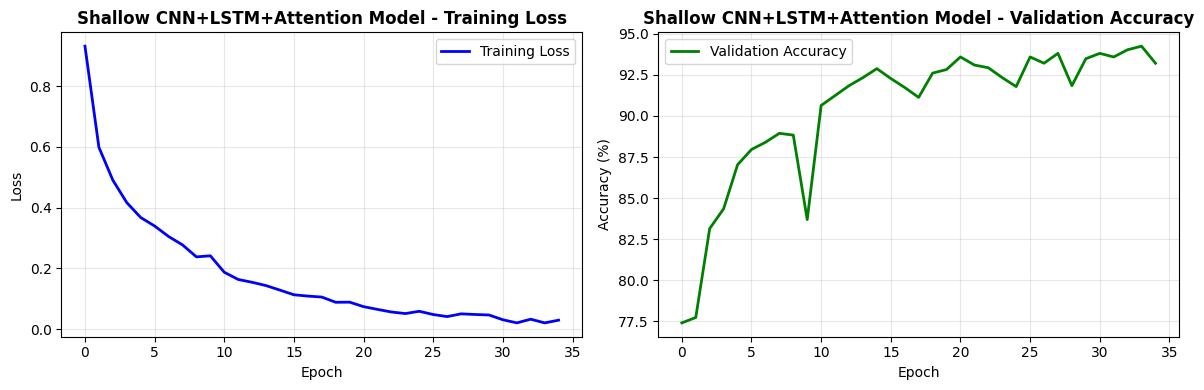

In [ ]:
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model")

In [ ]:
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth


In [ ]:
# Load the saved model state
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

print(f"Model loaded from {model_save_path}")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9702    0.9723    0.9712       469
   Beethoven     0.9453    0.8315    0.8847       457
      Mozart     0.8962    0.9574    0.9258       469
      Chopin     0.9207    0.9676    0.9436       432

    accuracy                         0.9321      1827
   macro avg     0.9331    0.9322    0.9313      1827
weighted avg     0.9333    0.9321    0.9314      1827



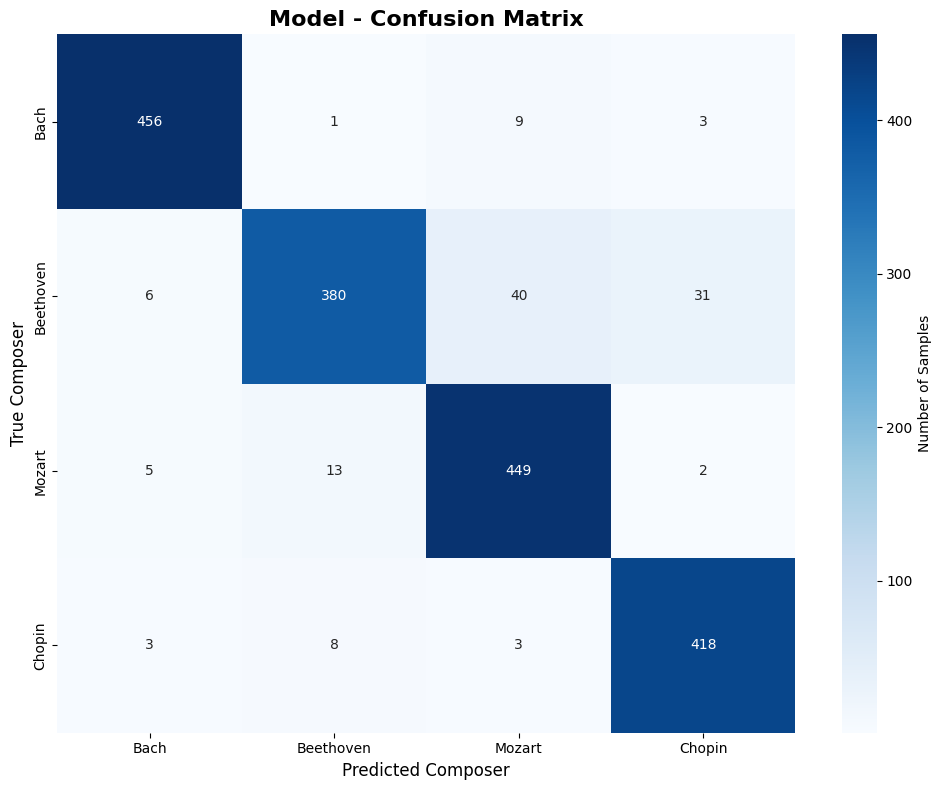


🎯 PER-CLASS ACCURACY:
Bach        : 0.9723 (97.23%)
Beethoven   : 0.8315 (83.15%)
Mozart      : 0.9574 (95.74%)
Chopin      : 0.9676 (96.76%)

🏆 OVERALL ACCURACY: 0.9321 (93.21%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 40 samples
Beethoven → Chopin: 31 samples
Mozart → Beethoven: 13 samples
Bach → Mozart: 9 samples
Chopin → Beethoven: 8 samples


In [ ]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

[CNN-LSTM-MLP] Epoch [1/15], Loss: 0.0091, Val Acc: 93.92%
[CNN-LSTM-MLP] Epoch [2/15], Loss: 0.0070, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [3/15], Loss: 0.0080, Val Acc: 94.14%
[CNN-LSTM-MLP] Epoch [4/15], Loss: 0.0116, Val Acc: 93.49%
[CNN-LSTM-MLP] Epoch [5/15], Loss: 0.0057, Val Acc: 93.60%
[CNN-LSTM-MLP] Epoch [6/15], Loss: 0.0049, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [7/15], Loss: 0.0029, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [8/15], Loss: 0.0047, Val Acc: 93.81%
[CNN-LSTM-MLP] Epoch [9/15], Loss: 0.0061, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [10/15], Loss: 0.0058, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [11/15], Loss: 0.0061, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [12/15], Loss: 0.0040, Val Acc: 94.20%
[CNN-LSTM-MLP] Epoch [13/15], Loss: 0.0042, Val Acc: 94.25%
[CNN-LSTM-MLP] Epoch [14/15], Loss: 0.0048, Val Acc: 94.03%
[CNN-LSTM-MLP] Epoch [15/15], Loss: 0.0040, Val Acc: 94.09%


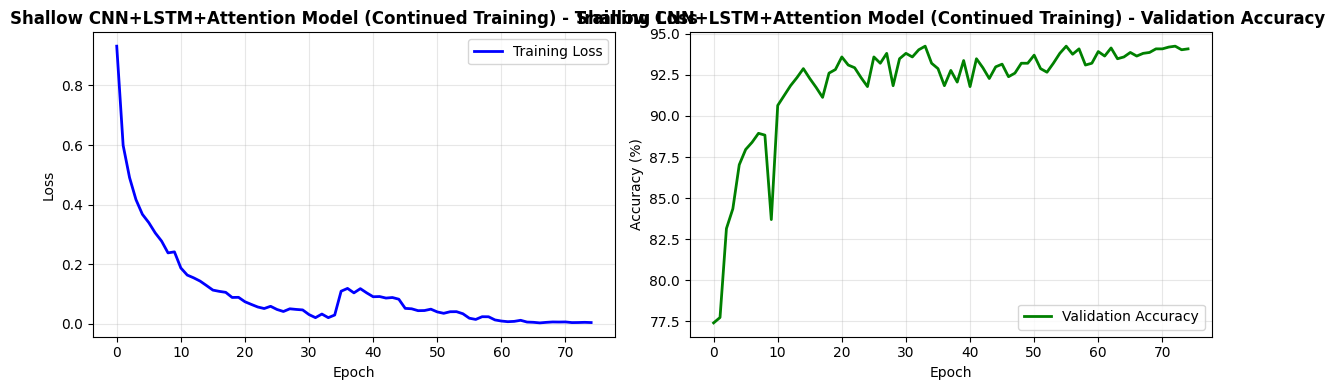

In [ ]:
# Continue training the model for 10 more epochs

# Load the saved model state
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

class_weights = torch.tensor([1.0, 1.3, 1.0, 1.0]).to(device)

# Set up loss, optimizer, scheduler (using the same ones from previous training)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Continue training for 10 more epochs
train_losses_cont, val_accuracies_cont = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, device=device
)

# Optionally, combine the training history for plotting
train_losses.extend(train_losses_cont)
val_accuracies.extend(val_accuracies_cont)

# Plot the updated training curves (if you have a plotting function)
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model (Continued Training)")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9665    0.9829    0.9746       469
   Beethoven     0.9254    0.8687    0.8962       457
      Mozart     0.9443    0.9403    0.9423       469
      Chopin     0.9251    0.9722    0.9481       432

    accuracy                         0.9409      1827
   macro avg     0.9403    0.9410    0.9403      1827
weighted avg     0.9407    0.9409    0.9404      1827



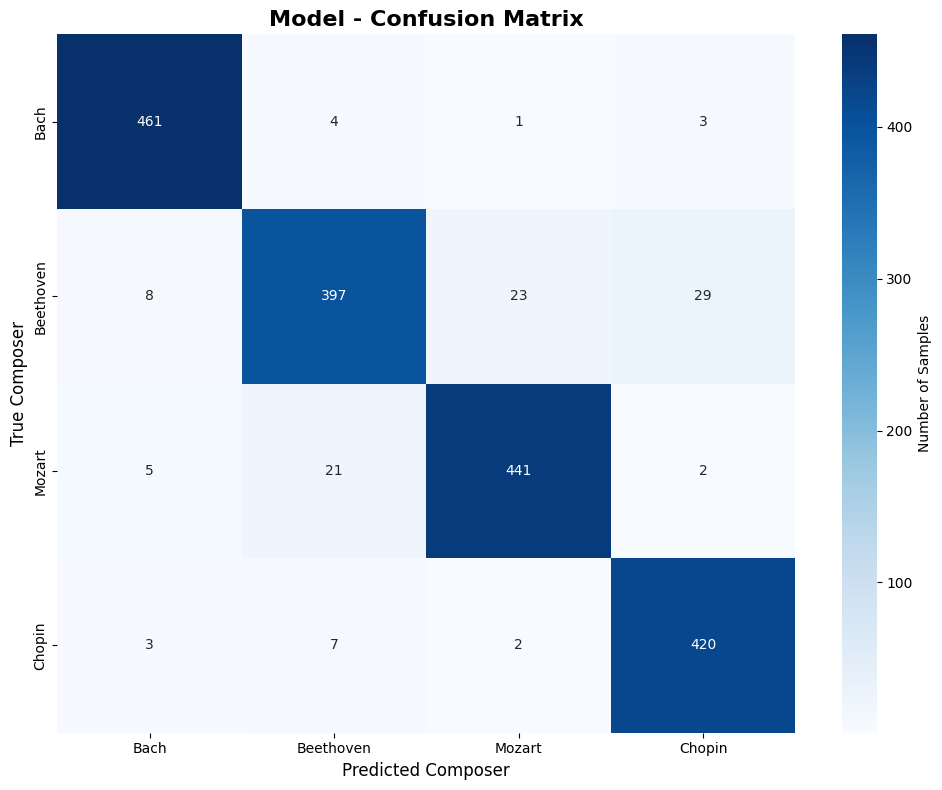


🎯 PER-CLASS ACCURACY:
Bach        : 0.9829 (98.29%)
Beethoven   : 0.8687 (86.87%)
Mozart      : 0.9403 (94.03%)
Chopin      : 0.9722 (97.22%)

🏆 OVERALL ACCURACY: 0.9409 (94.09%)

❌ MOST CONFUSED PAIRS:
Beethoven → Chopin: 29 samples
Beethoven → Mozart: 23 samples
Mozart → Beethoven: 21 samples
Beethoven → Bach: 8 samples
Chopin → Beethoven: 7 samples


In [ ]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [ ]:
model_save_path_2 = "../saved_models/shallow_cnn_lstm_attention_model_2.pth"
torch.save(model.state_dict(), model_save_path_2)
print(f"Model saved to {model_save_path_2}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth


# 8. Conclusion and Future Work

In this project, we developed and evaluated multiple deep learning architectures for the task of classical composer recognition using MIDI data. Feature extraction was explored through 3 main techniques: Mido, PrettyMIDI, and Music21. After several attempts, PrettyMIDI was the most effective at generating piano roll representations, while Mido's numerical features added information that was almost complimentary. 

Across all three main modeling strategies, the highest performance came from the multi-modal architecture that combined CNN, BiLSTM, and MLP components (achieving an accuracy of 94%). This approach leverged both engineered features and piano roll data to capture temporal patterns in the music. Other models, such as the CNN-BiLSTM with attention using only PrettyMIDI or Mido + PrettyMIDI features, produced reasonable results. However, they showed class specific weaknesses, specifically in distinguishing between Beethoven and Mozart, where feature distributions overlapped quite a bit.

While these results demonstrate a strong potential for composer classification from MIDI data, there is room for improvement. Future work could focus on expanding the dataset to enhance generalization and reduce imbalance. As well as, experimenting with data augmentation techniques and tuning hyperparameters. With these enhancements, the models could move one step closer to real world deployment.
